In [4]:
import os, time, gc, random
import datatable as dt
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)

import dabl

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

## 读取数据

pandas读取需要2min，使用datatable读取更快，可选还有cudf

In [5]:
%%time
data_path = '/kaggle/working/input/train.csv'
train_data_datatable = dt.fread(data_path)

CPU times: user 10min 37s, sys: 20.3 s, total: 10min 57s
Wall time: 13.7 s


In [6]:
%%time
train_data = train_data_datatable.to_pandas()

CPU times: user 41.6 s, sys: 5.46 s, total: 47.1 s
Wall time: 5.39 s


## Resp

71

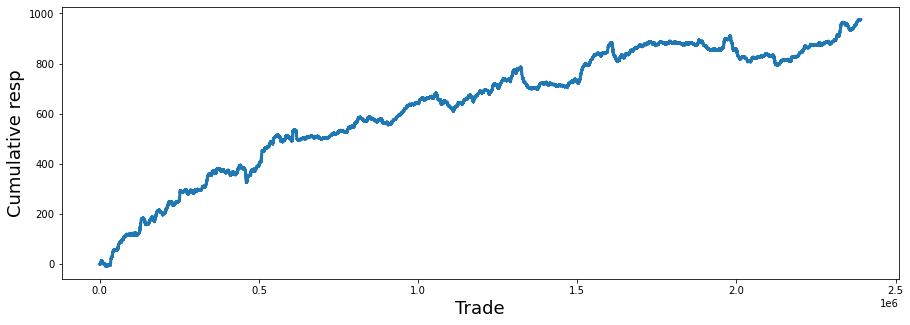

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
balance = pd.Series(train_data['resp']).cumsum()
ax.set_xlabel("Trade", fontsize=18)
ax.set_ylabel("Cumulative resp", fontsize=18)
balance.plot(lw=3)
del balance
gc.collect()

500天时长的数据，其累计的resp如下，总体是上升的趋势

2725

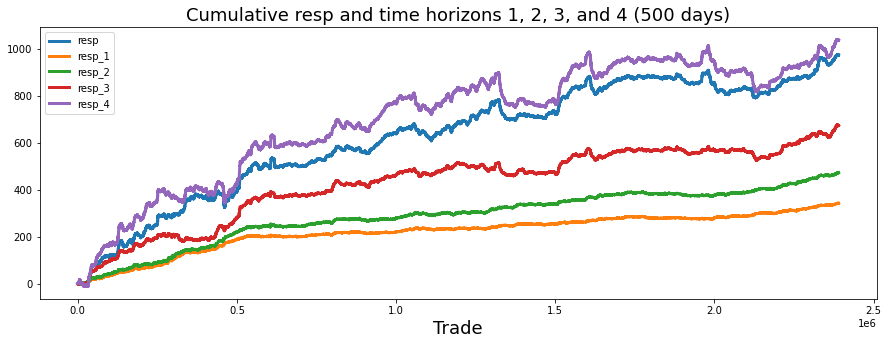

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
resp_1= pd.Series(train_data['resp_1']).cumsum()
resp_2= pd.Series(train_data['resp_2']).cumsum()
resp_3= pd.Series(train_data['resp_3']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left")
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect()

4条时间序列，分别是resp,resp_1,resp_2,resp_3,resp_4,其变化趋势如下，可发现resp和resp_4的曲线接近，resp和resp_3以及resp_4的变化趋势是相同的，resp_1和resp_2不明显

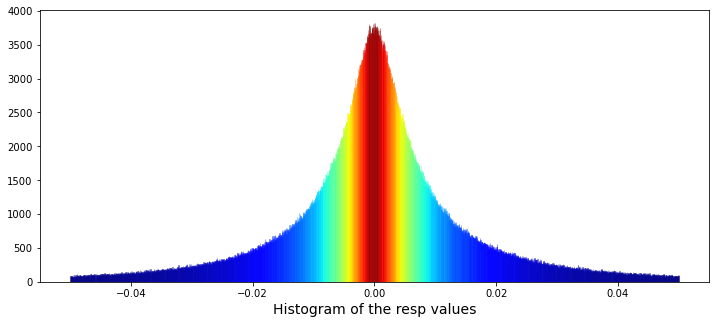

The minimum value for resp is: -0.54938
The maximum value for resp is: 0.44846
Skew of resp is: 0.10
Kurtosis of resp is: 17.36


In [6]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['resp'], 
             bins=3000, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show()
gc.collect()
min_resp = train_data['resp'].min()
print('The minimum value for resp is: %.5f' % min_resp)
max_resp = train_data['resp'].max()
print('The maximum value for resp is: %.5f' % max_resp)
print("Skew of resp is: %.2f" %train_data['resp'].skew() )
print("Kurtosis of resp is: %.2f"  %train_data['resp'].kurtosis() )

想法一：可对resp进行fit，features -> resp

## Weight

每次交易都有weight和resp，weight表示当前交易的权重，当权重为0，此次交易将不对整体的收益有帮组

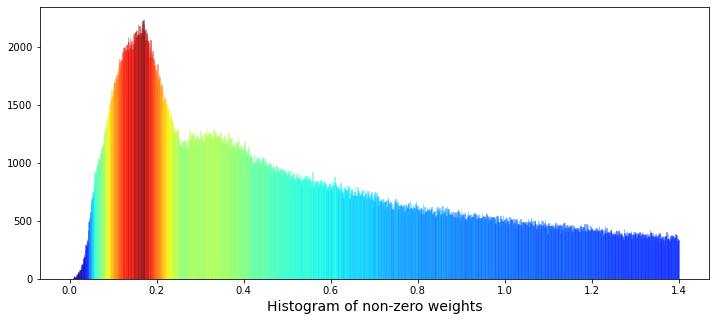

Percentage of zero weights is: 17%
The minimum weight is: 0.00
The maximum weight was: 167.29


In [7]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['weight'], 
             bins=1400, 
             kde_kws={"clip":(0.001,1.4)}, 
             hist_kws={"range":(0.001,1.4)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show()
del values
gc.collect()
percent_zeros = (100/train_data.shape[0])*((train_data.weight.values == 0).sum())
print('Percentage of zero weights is: %i' % percent_zeros +"%")
min_weight = train_data['weight'].min()
print('The minimum weight is: %.2f' % min_weight)
max_weight = train_data['weight'].max()
print('The maximum weight was: %.2f' % max_weight)

发现weight无负权重，最大权重超过100，其中17%的权重对应的Trade是无意义的，在fit时可去掉，并且weight分布有两个峰，分别是weight为0.17和0.34，maybe是对应着买卖的分布。

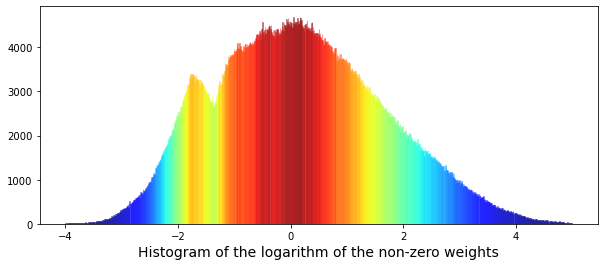

0

In [8]:
train_data_nonZero = train_data.query('weight > 0').reset_index(drop = True)
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(train_data_nonZero['weight']), 
             bins=1000, 
             kde_kws={"clip":(-4,5)}, 
             hist_kws={"range":(-4,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
plt.show()
gc.collect()

对weight取log分布，发现基本满足两个高斯分布，可fit，features -> weight

## Cumulative return

计算每天多次的Trade的累积和: weight * resp

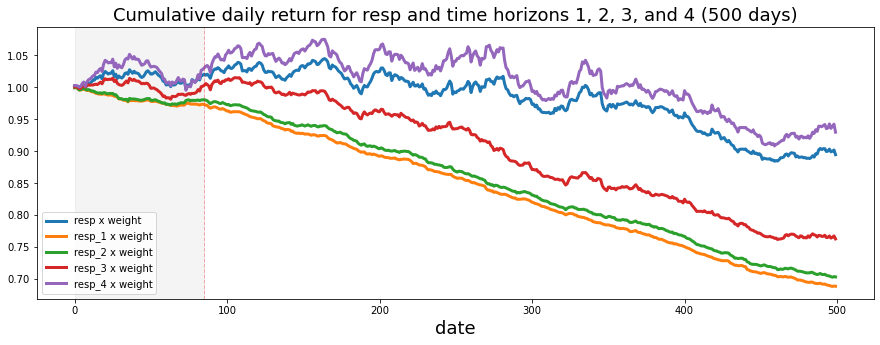

In [9]:
train_data['weight_resp']   = train_data['weight']*train_data['resp']
train_data['weight_resp_1'] = train_data['weight']*train_data['resp_1']
train_data['weight_resp_2'] = train_data['weight']*train_data['resp_2']
train_data['weight_resp_3'] = train_data['weight']*train_data['resp_3']
train_data['weight_resp_4'] = train_data['weight']*train_data['resp_4']

fig, ax = plt.subplots(figsize=(15, 5))
resp    = pd.Series(1+(train_data.groupby('date')['weight_resp'].mean())).cumprod()
resp_1  = pd.Series(1+(train_data.groupby('date')['weight_resp_1'].mean())).cumprod()
resp_2  = pd.Series(1+(train_data.groupby('date')['weight_resp_2'].mean())).cumprod()
resp_3  = pd.Series(1+(train_data.groupby('date')['weight_resp_3'].mean())).cumprod()
resp_4  = pd.Series(1+(train_data.groupby('date')['weight_resp_4'].mean())).cumprod()
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Cumulative daily return for resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp.plot(lw=3, label='resp x weight')
resp_1.plot(lw=3, label='resp_1 x weight')
resp_2.plot(lw=3, label='resp_2 x weight')
resp_3.plot(lw=3, label='resp_3 x weight')
resp_4.plot(lw=3, label='resp_4 x weight')
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
plt.legend(loc="lower left")

可发现resp_1, resp_2, resp_3表示的是比较保守的策略，获得的收益最低。

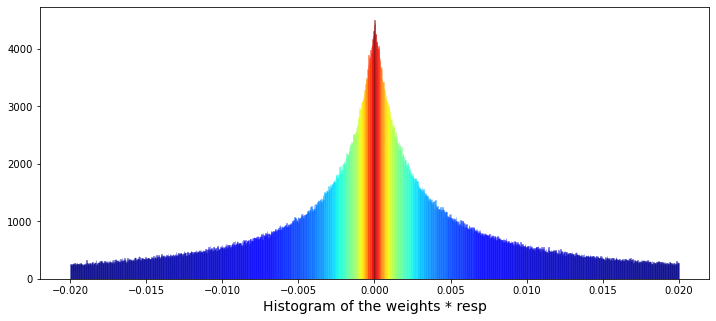

In [10]:
train_data_no_0 = train_data.query('weight > 0').reset_index(drop = True)
train_data_no_0['wAbsResp'] = train_data_no_0['weight'] * (train_data_no_0['resp'])
#plot
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data_no_0['wAbsResp'], 
             bins=1500, 
             kde_kws={"clip":(-0.02,0.02)}, 
             hist_kws={"range":(-0.02,0.02)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the weights * resp", size=14)
plt.show()

weight * resp 每天的Trade和的分布，可fit

## Time

ts_id: 表示每天交易达成的次数，此处参考[did Jane Street modify their trading model around day 85?](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201930)

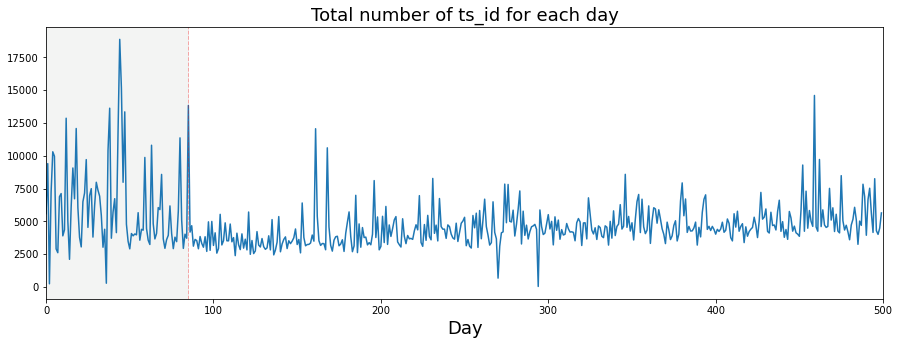

In [11]:
trades_per_day = train_data.groupby(['date'])['ts_id'].count()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of ts_id for each day", fontsize=18)
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
plt.show()

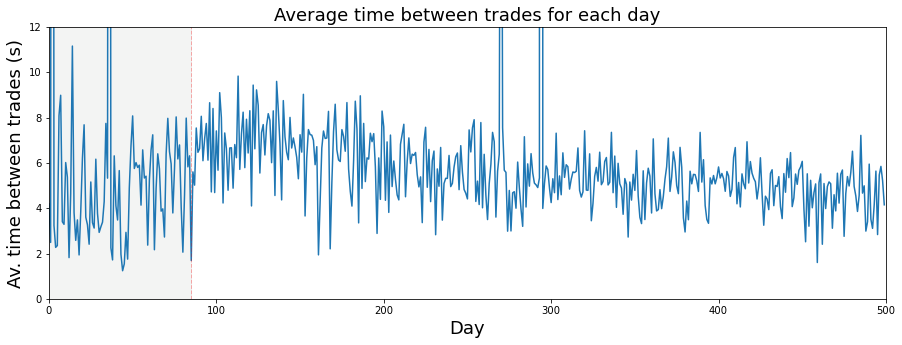

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(23400/trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_ylabel ("Av. time between trades (s)", fontsize=18)
ax.set_title ("Average time between trades for each day", fontsize=18)
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0)
ax.set_ylim(ymax=12)
plt.show()

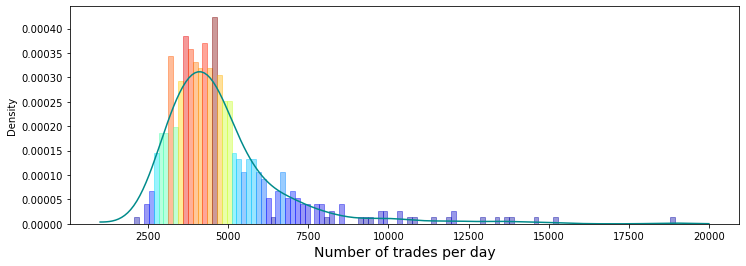

In [13]:
plt.figure(figsize = (12,4))
# the minimum has been set to 1000 so as not to draw the partial days like day 2 and day 294
# the maximum number of trades per day is 18884
# I have used 125 bins for the 500 days
ax = sns.distplot(trades_per_day, 
             bins=125, 
             kde_kws={"clip":(1000,20000)}, 
             hist_kws={"range":(1000,20000)},
             color='darkcyan', 
             kde=True);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Number of trades per day", size=14)
plt.show()

In [14]:
volitile_days = pd.DataFrame(trades_per_day[trades_per_day > 9000])
volitile_days.T

date    1      4     5      12    16     18    24     37     38     43   \
ts_id  9401  10305  9965  12866  9069  12082  9708  10399  13631  11872   

date     44     45     47    59     63     80     85     161    168   452  \
ts_id  18884  15174  13351  9873  10805  11366  13842  12064  10607  9294   

date     459   462  
ts_id  14603  9718

每天Trade次数分布图，并且有着异常交易次数的基本都是在85天之前，可把85天前的数据去除。

## The features

train.csv中包含feature_{0...129}，表示的是真实的股票数据

### feature_0

 1    1207005
-1    1183486
Name: feature_0, dtype: int64

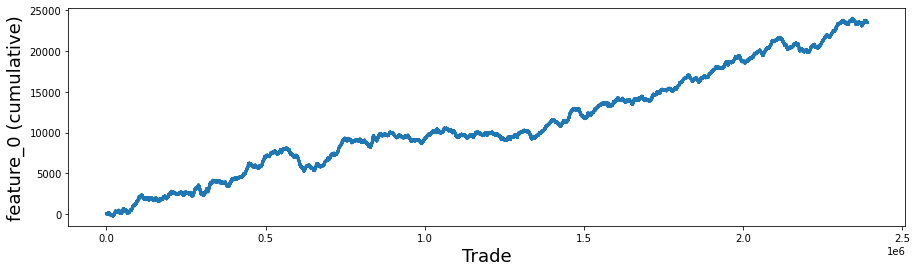

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
feature_0 = pd.Series(train_data['feature_0']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("feature_0 (cumulative)", fontsize=18);
feature_0.plot(lw=3)
train_data['feature_0'].value_counts()

feature_0中只有+1和-1，两者的数量大体相当

2656

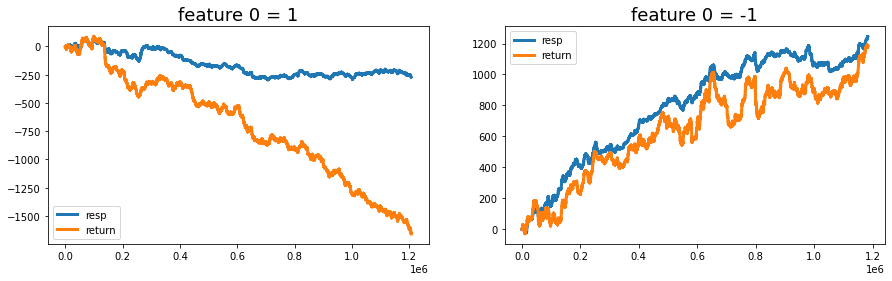

In [16]:
feature_0_is_plus_one  = train_data.query('feature_0 ==  1').reset_index(drop = True)
feature_0_is_minus_one = train_data.query('feature_0 == -1').reset_index(drop = True)
# the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((pd.Series(feature_0_is_plus_one['resp']).cumsum()), lw=3, label='resp')
ax1.plot((pd.Series(feature_0_is_plus_one['resp']*feature_0_is_plus_one['weight']).cumsum()), lw=3, label='return')
ax2.plot((pd.Series(feature_0_is_minus_one['resp']).cumsum()), lw=3, label='resp')
ax2.plot((pd.Series(feature_0_is_minus_one['resp']*feature_0_is_minus_one['weight']).cumsum()), lw=3, label='return')
ax1.set_title ("feature 0 = 1", fontsize=18)
ax2.set_title ("feature 0 = -1", fontsize=18)
ax1.legend(loc="lower left")
ax2.legend(loc="upper left");

del feature_0_is_plus_one
del feature_0_is_minus_one
gc.collect()

当画出feature_0相对resp和return累计和(resp * weight)的曲线图时，发现feature_0=1和feature_0=-1可区分两种分布，所以feature_0代表bid/ask, long/short, or call/put？

### feature_{1...129}

6115

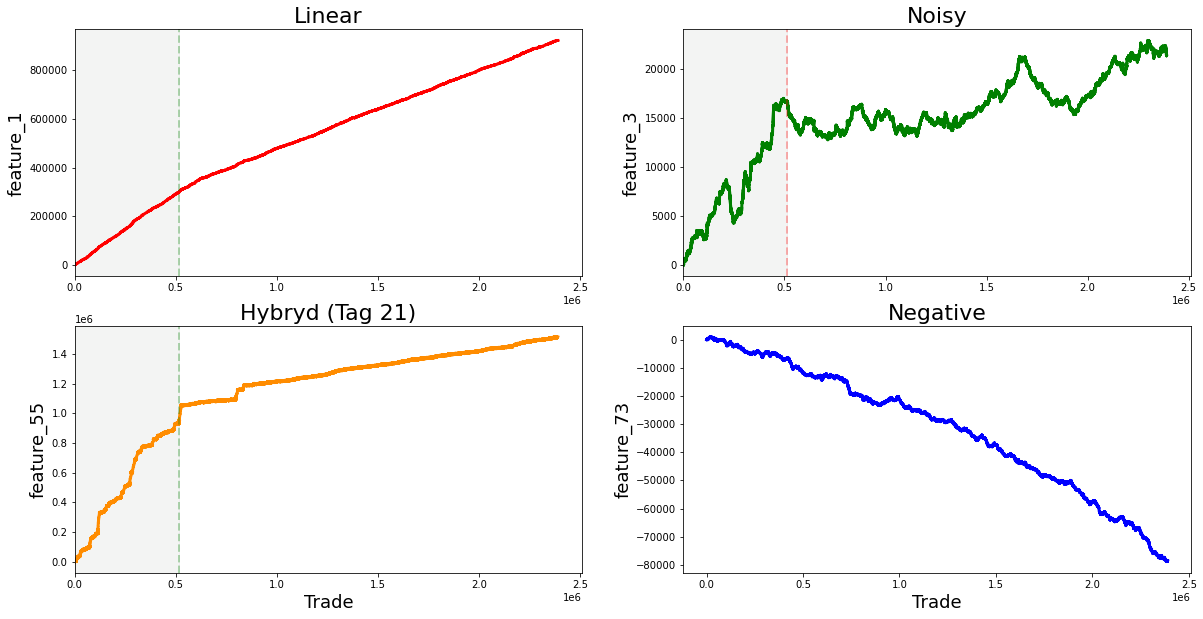

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,10))

ax1.plot((pd.Series(train_data['feature_1']).cumsum()), lw=3, color='red')
ax1.set_title ("Linear", fontsize=22);
ax1.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
ax1.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax1.set_xlim(xmin=0)
ax1.set_ylabel ("feature_1", fontsize=18);

ax2.plot((pd.Series(train_data['feature_3']).cumsum()), lw=3, color='green')
ax2.set_title ("Noisy", fontsize=22);
ax2.axvline(x=514052, linestyle='--', alpha=0.3, c='red', lw=2)
ax2.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax2.set_xlim(xmin=0)
ax2.set_ylabel ("feature_3", fontsize=18);

ax3.plot((pd.Series(train_data['feature_55']).cumsum()), lw=3, color='darkorange')
ax3.set_title ("Hybryd (Tag 21)", fontsize=22);
ax3.set_xlabel ("Trade", fontsize=18)
ax3.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
ax3.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax3.set_xlim(xmin=0)
ax3.set_ylabel ("feature_55", fontsize=18);

ax4.plot((pd.Series(train_data['feature_73']).cumsum()), lw=3, color='blue')
ax4.set_title ("Negative", fontsize=22)
ax4.set_xlabel ("Trade", fontsize=18)
ax4.set_ylabel ("feature_73", fontsize=18);
gc.collect()

feature共有四种特征，分别如图所示，其他特征如下：
- 1
- 7, 9, 11, 13, 15
- 17, 19, 21, 23, 25
- 18, 20, 22, 24, 26
- 27, 29, 21, 33, 35
- 28, 30, 32, 34, 36
- 84, 85, 86, 87, 88
- 90, 91, 92, 93, 94
- 96, 97, 98, 99, 100
- 102 (strong change in gradient), 103, 104, 105, 106
as well as 41, 46, 47, 48, 49, 50, 51, 53, 54, 69, 89, 95 (strong change in gradient), 101, 107 (strong change in gradient), 108, 110, 111, 113, 114, 115, 116, 117, 118, 119 (strong change in gradient), 120, 122, and 124.

### Tag14: feature_{41, 42, 43}

115

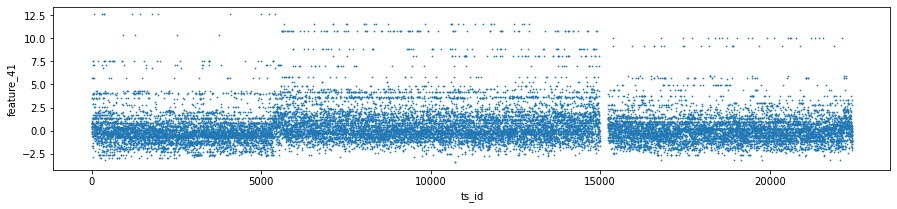

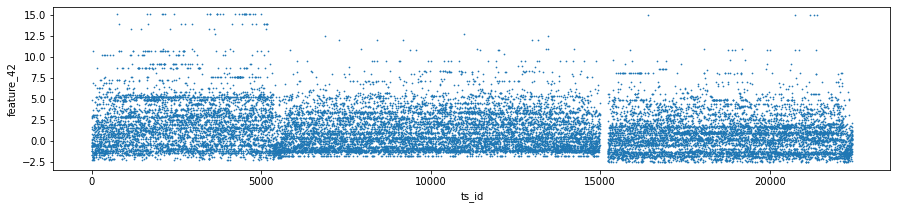

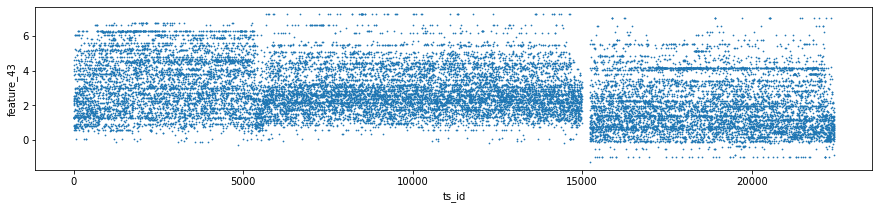

In [18]:
day_0 = train_data.loc[train_data['date'] == 0]
day_1 = train_data.loc[train_data['date'] == 1]
day_3 = train_data.loc[train_data['date'] == 3]
three_days = pd.concat([day_0, day_1, day_3])
three_days.plot.scatter(x='ts_id', y='feature_41', s=0.5, figsize=(15,3))
three_days.plot.scatter(x='ts_id', y='feature_42', s=0.5, figsize=(15,3))
three_days.plot.scatter(x='ts_id', y='feature_43', s=0.5, figsize=(15,3))
del day_1
del day_3
gc.collect()

发现feature_{41, 42, 43}出现分层的现象

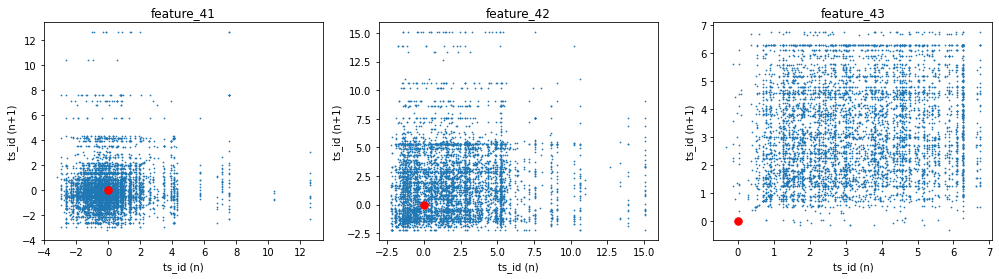

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
lag_plot(day_0['feature_41'], lag=1, s=0.5, ax=ax[0])
lag_plot(day_0['feature_42'], lag=1, s=0.5, ax=ax[1])
lag_plot(day_0['feature_43'], lag=1, s=0.5, ax=ax[2])
ax[0].title.set_text('feature_41')
ax[0].set_xlabel("ts_id (n)")
ax[0].set_ylabel("ts_id (n+1)")
ax[1].title.set_text('feature_42')
ax[1].set_xlabel("ts_id (n)")
ax[1].set_ylabel("ts_id (n+1)")
ax[2].title.set_text('feature_43')
ax[2].set_xlabel("ts_id (n)")
ax[2].set_ylabel("ts_id (n+1)")

ax[0].plot(0, 0, 'r.', markersize=15.0)
ax[1].plot(0, 0, 'r.', markersize=15.0)
ax[2].plot(0, 0, 'r.', markersize=15.0);
gc.collect();

时间序列的自相关性分析

### Tag18: feature_{44, 45}

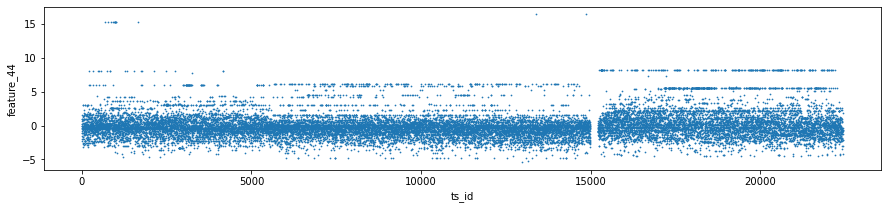

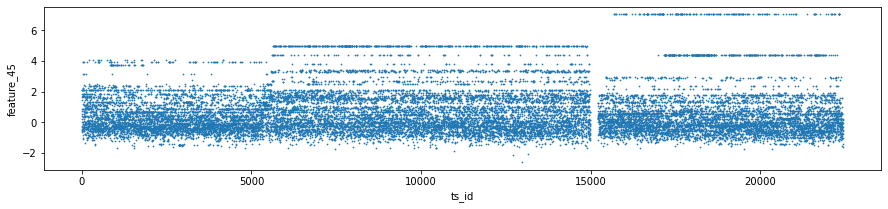

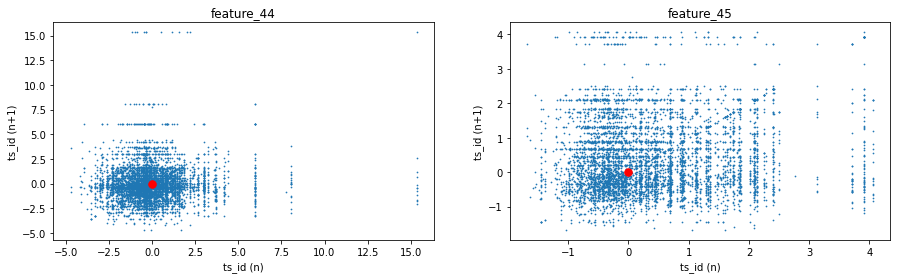

In [20]:
three_days.plot.scatter(x='ts_id', y='feature_44', s=0.5, figsize=(15,3));
three_days.plot.scatter(x='ts_id', y='feature_45', s=0.5, figsize=(15,3));
gc.collect();
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
lag_plot(day_0['feature_44'], lag=1, s=0.5, ax=ax[0])
lag_plot(day_0['feature_45'], lag=1, s=0.5, ax=ax[1])
ax[0].title.set_text('feature_44')
ax[0].set_xlabel("ts_id (n)")
ax[0].set_ylabel("ts_id (n+1)")
ax[1].title.set_text('feature_45')
ax[1].set_xlabel("ts_id (n)")
ax[1].set_ylabel("ts_id (n+1)")

ax[0].plot(0, 0, 'r.', markersize=15.0)
ax[1].plot(0, 0, 'r.', markersize=15.0);
gc.collect();

feature_{44, 45}和Tag14有相似的分层情况，但更多集中在原点0处

### Tag22: feature_{60, 68}

Tag22: 60, 61, 62, 63, 64, 65, 66, 67, 68

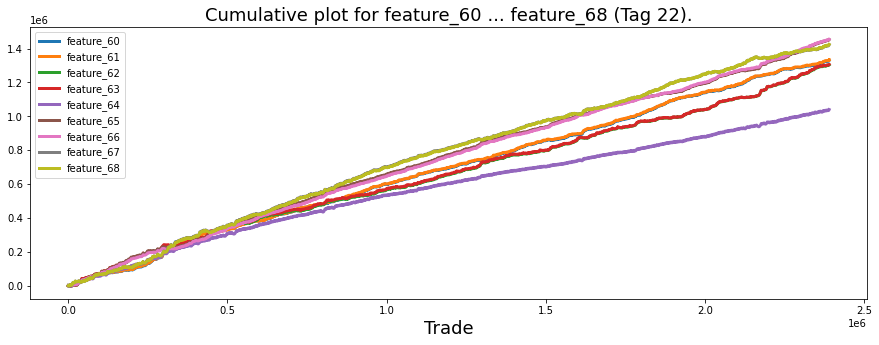

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_60= pd.Series(train_data['feature_60']).cumsum()
feature_61= pd.Series(train_data['feature_61']).cumsum()
feature_62= pd.Series(train_data['feature_62']).cumsum()
feature_63= pd.Series(train_data['feature_63']).cumsum()
feature_64= pd.Series(train_data['feature_64']).cumsum()
feature_65= pd.Series(train_data['feature_65']).cumsum()
feature_66= pd.Series(train_data['feature_66']).cumsum()
feature_67= pd.Series(train_data['feature_67']).cumsum()
feature_68= pd.Series(train_data['feature_68']).cumsum()
#feature_69= pd.Series(train_data['feature_69']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for feature_60 ... feature_68 (Tag 22).", fontsize=18)
feature_60.plot(lw=3)
feature_61.plot(lw=3)
feature_62.plot(lw=3)
feature_63.plot(lw=3)
feature_64.plot(lw=3)
feature_65.plot(lw=3)
feature_66.plot(lw=3)
feature_67.plot(lw=3)
feature_68.plot(lw=3)
#feature_69.plot(lw=3)
plt.legend(loc="upper left");
del feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66 ,feature_67, feature_68
gc.collect();


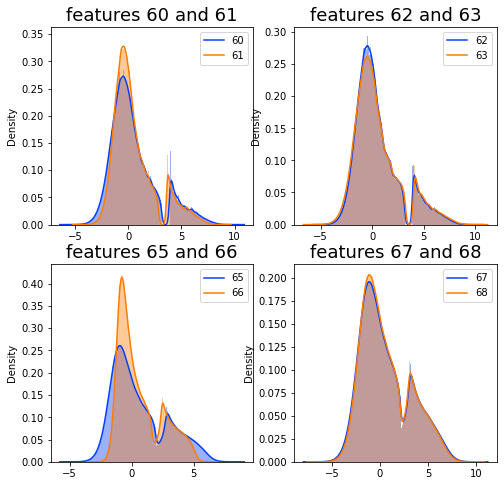

In [22]:
sns.set_palette("bright")

fig, axes = plt.subplots(2,2,figsize=(8,8))

sns.distplot(train_data[['feature_60']], hist=True, bins=200,  ax=axes[0,0])
sns.distplot(train_data[['feature_61']], hist=True, bins=200,  ax=axes[0,0])
axes[0,0].set_title ("features 60 and 61", fontsize=18)
axes[0,0].legend(labels=['60', '61'])

sns.distplot(train_data[['feature_62']], hist=True,  bins=200, ax=axes[0,1])
sns.distplot(train_data[['feature_63']], hist=True,  bins=200, ax=axes[0,1])
axes[0,1].set_title ("features 62 and 63", fontsize=18)
axes[0,1].legend(labels=['62', '63'])

sns.distplot(train_data[['feature_65']], hist=True,  bins=200, ax=axes[1,0])
sns.distplot(train_data[['feature_66']], hist=True,  bins=200, ax=axes[1,0])
axes[1,0].set_title ("features 65 and 66", fontsize=18)
axes[1,0].legend(labels=['65', '66'])


sns.distplot(train_data[['feature_67']], hist=True,  bins=200, ax=axes[1,1])
sns.distplot(train_data[['feature_68']], hist=True,  bins=200, ax=axes[1,1])
axes[1,1].set_title ("features 67 and 68", fontsize=18)
axes[1,1].legend(labels=['67', '68'])

plt.show();
gc.collect();

feature_{60, 61}，feature_{62, 63}，feature_{65, 66}feature_{67, 68}这几组都有相似的趋势。

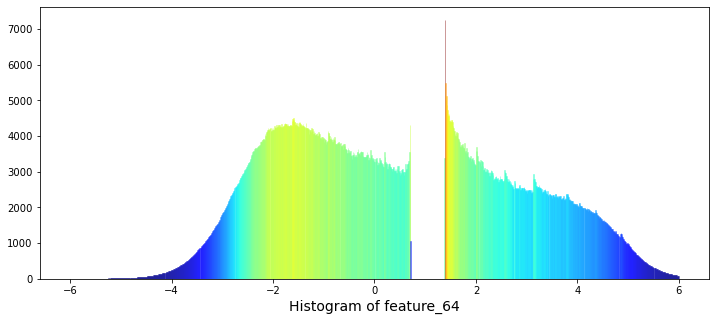

In [23]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['feature_64'], 
             bins=1200, 
             kde_kws={"clip":(-6,6)}, 
             hist_kws={"range":(-6,6)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of feature_64", size=14)
plt.show();
del values
gc.collect();

feature_{64}中有巨大的分层情况，区间在0.7到1.38，开盘时间？

### Noisy feature
- 3, 4, 5, 6
- 8, 10, 12, 14, 16
- 37, 38, 39, 40
- 72, 73, 74, 75, 76
- 78, 79, 80, 81, 82
- 83

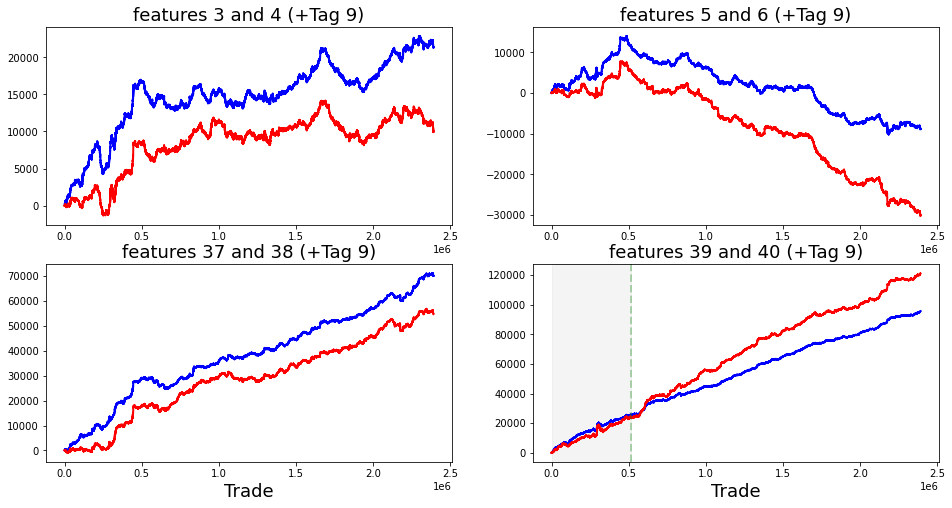

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,8))
ax1.set_title ("features 3 and 4 (+Tag 9)", fontsize=18);
ax1.plot((pd.Series(train_data['feature_3']).cumsum()), lw=2, color='blue')
ax1.plot((pd.Series(train_data['feature_4']).cumsum()), lw=2, color='red')

ax2.set_title ("features 5 and 6 (+Tag 9)", fontsize=18);
ax2.plot((pd.Series(train_data['feature_5']).cumsum()), lw=2, color='blue')
ax2.plot((pd.Series(train_data['feature_6']).cumsum()), lw=2, color='red')

ax3.set_title ("features 37 and 38 (+Tag 9)", fontsize=18);
ax3.plot((pd.Series(train_data['feature_37']).cumsum()), lw=2, color='blue')
ax3.plot((pd.Series(train_data['feature_38']).cumsum()), lw=2, color='red')
ax3.set_xlabel ("Trade", fontsize=18)

ax4.set_title ("features 39 and 40 (+Tag 9)", fontsize=18);
ax4.plot((pd.Series(train_data['feature_39']).cumsum()), lw=2, color='blue')
ax4.plot((pd.Series(train_data['feature_40']).cumsum()), lw=2, color='red')
ax4.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
ax4.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax4.set_xlabel ("Trade", fontsize=18)
#ax4.axvline(x=514052, linestyle='--', alpha=0.3, c='black', lw=1)
#ax4.axvspan(0,  514052, color=sns.xkcd_rgb['grey'], alpha=0.1);
gc.collect();

### Tag19: feature_51

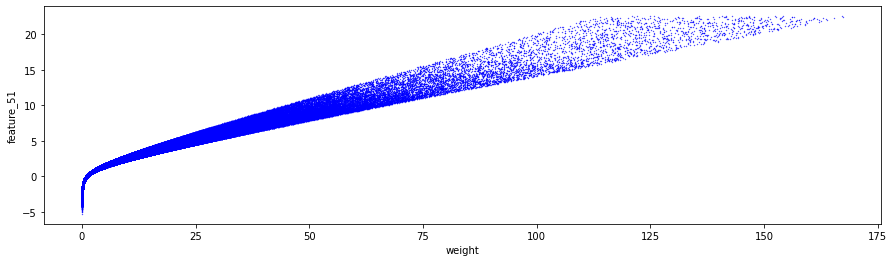

In [25]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(train_data_nonZero.weight, train_data_nonZero.feature_51, s=0.1, color='b')
ax.set_xlabel('weight')
ax.set_ylabel('feature_51')
plt.show();

从一些notebook中可知，feature_51表示是股票的日均成交量

### Tag19: feature_52

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


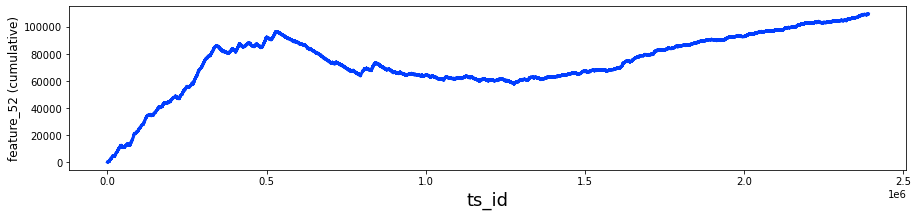

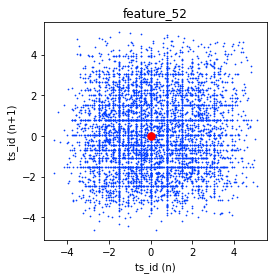

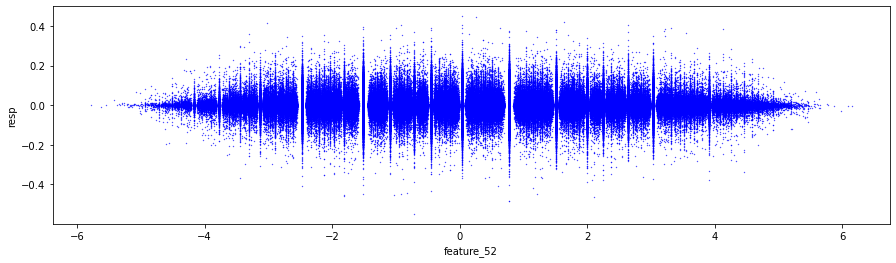

In [26]:
fig, ax = plt.subplots(figsize=(15, 3))
feature_0 = pd.Series(train_data['feature_52']).cumsum()
ax.set_xlabel ("ts_id", fontsize=18)
ax.set_ylabel ("feature_52 (cumulative)", fontsize=12);
feature_0.plot(lw=3);

fig, ax = plt.subplots(1,1, figsize=(4, 4))
lag_plot(day_0['feature_52'], s=0.5, ax=ax)
ax.title.set_text('feature_52')
ax.set_xlabel("ts_id (n)")
ax.set_ylabel("ts_id (n+1)")
ax.plot(0, 0, 'r.', markersize=15.0);

fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(train_data_nonZero.feature_52, train_data_nonZero.resp, s=0.1, color='b')
ax.set_xlabel('feature_52')
ax.set_ylabel('resp')
plt.show();

### Negative feature
feature_{73, 75, 76, 77(noisy), 79, 81(noisy), 82}，这些feature是属于Tag13的

### Hybrid feature
feature_{55, 56, 57, 58, 59}，属于Tag21的

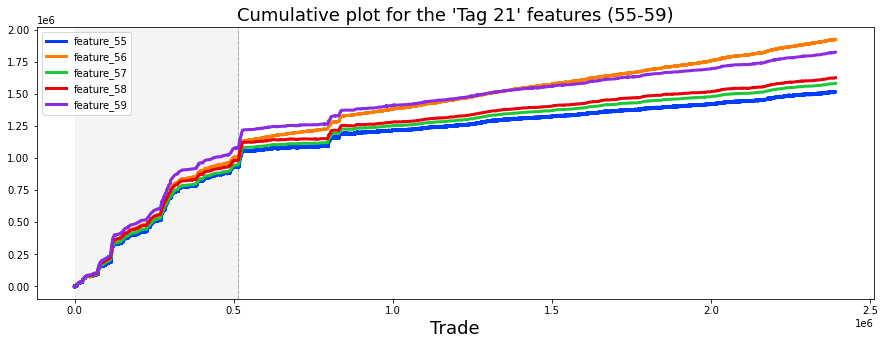

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_55= pd.Series(train_data['feature_55']).cumsum()
feature_56= pd.Series(train_data['feature_56']).cumsum()
feature_57= pd.Series(train_data['feature_57']).cumsum()
feature_58= pd.Series(train_data['feature_58']).cumsum()
feature_59= pd.Series(train_data['feature_59']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for the 'Tag 21' features (55-59)", fontsize=18)
ax.axvline(x=514052, linestyle='--', alpha=0.3, c='black', lw=1)
ax.axvspan(0,  514052, color=sns.xkcd_rgb['grey'], alpha=0.1)
feature_55.plot(lw=3)
feature_56.plot(lw=3)
feature_57.plot(lw=3)
feature_58.plot(lw=3)
feature_59.plot(lw=3)
plt.legend(loc="upper left");
gc.collect();

呈阶梯状，分别在0.2，0.5，0.8处有step

此时猜测各个feature和resp的关系：
如果
- feature_55 is related to resp_1
- feature_56 is related to resp_4
- feature_57 is related to resp_2
- feature_58 is related to resp_3
- feature_59 is related to resp
那么
- Tag 0 represents resp_4 features
- Tag 1 represents resp features
- Tag 2 represents resp_3 features
- Tag 3 represents resp_2 features
- Tag 4 represents resp_1 features
举例
- 和resp_1相关的feature：7, 8, 17, 18, 27, 28, 55, 72, 78, 84, 90, 96, 102, 108, 114, 120, and 121 (Note: 79.6%).
- 和resp_2相关的feature：11, 12, 21, 22, 31, 32, 57, 74, 80, 86, 92, 98, 104, 110, 116, 124, and 125 (Note: 15.2%).
- 和resp_3相关的feature：13, 14, 23, 24, 33, 34, 58, 75, 81, 87, 93, 99, 105, 111, 117, 126, and 127.
- 和resp_4相关的feature：9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, and 123.
- 和resp相关的feature：15, 16, 25, 26, 35, 36, 59, 76, 82, 88, 94, 100, 106, 112, 118, 128, and 129.

可fit

## features.csv
'metadata pertaining to the anonymized features'
共有29个tag，用0和1表示

In [30]:
feature_tags = pd.read_csv("/kaggle/working/input/features.csv" ,index_col=0)
# convert to binary
feature_tags = feature_tags*1
# plot a transposed dataframe
feature_tags.T.style.background_gradient(cmap='Oranges')

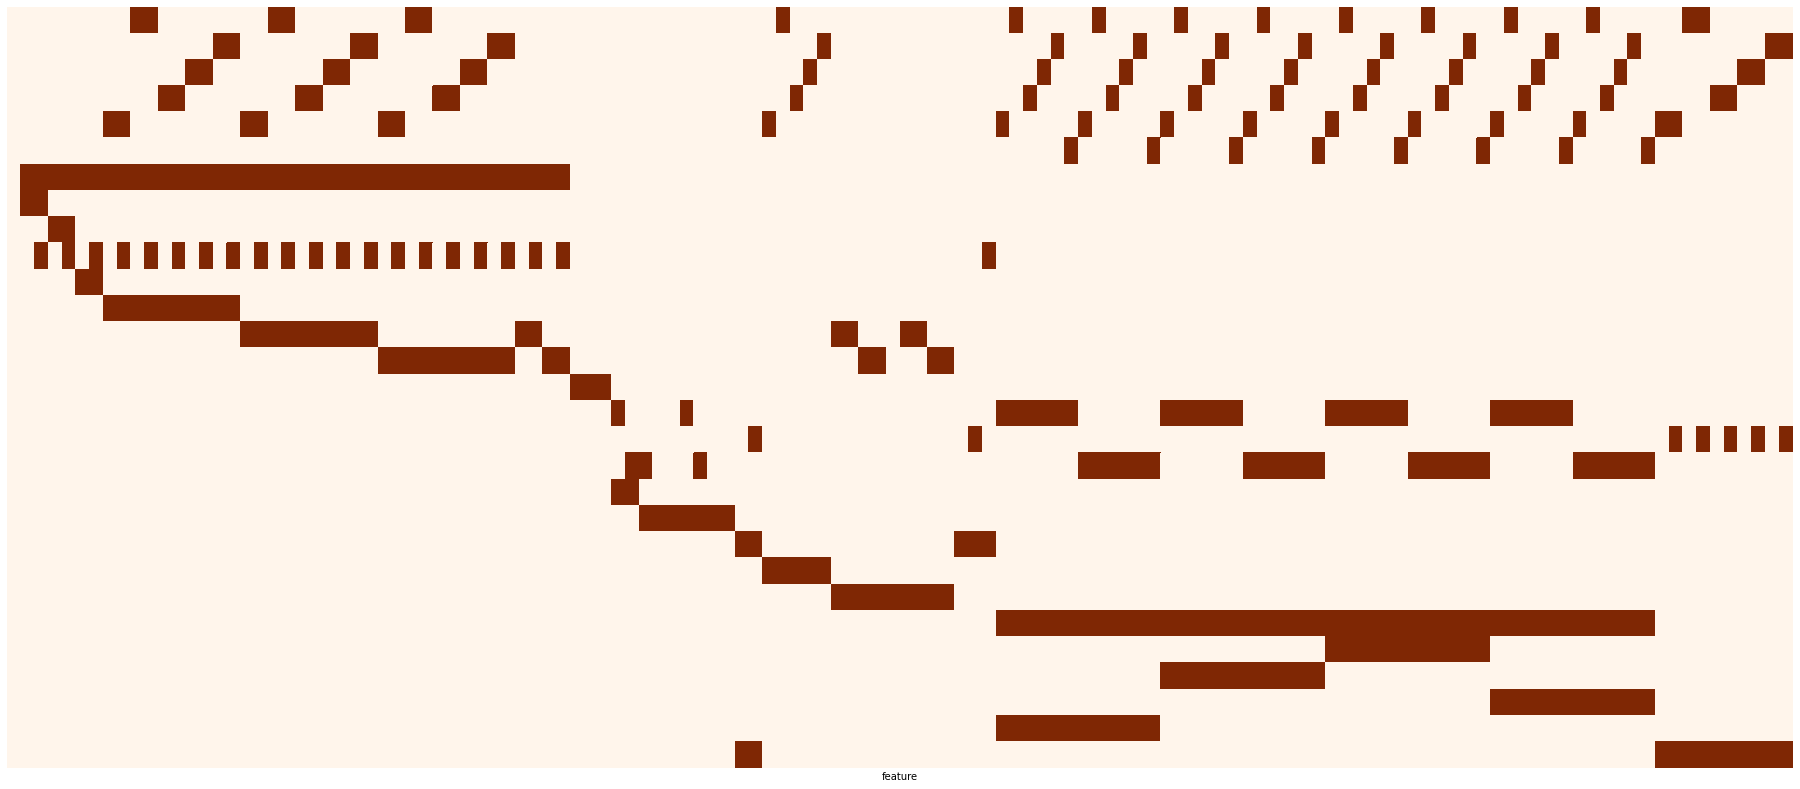

In [31]:
plt.figure(figsize=(32,14))
sns.heatmap(feature_tags.T,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap="Oranges");

In [35]:
tag_sum = pd.DataFrame(feature_tags.T.sum(axis=0),columns=['Number of tags'])
tag_sum.T

feature         feature_0  feature_1  feature_2  feature_3  feature_4  \
Number of tags          0          2          3          2          3   

feature         feature_5  feature_6  feature_7  feature_8  feature_9  \
Number of tags          2          3          3          4          3   

feature         feature_10  feature_11  feature_12  feature_13  feature_14  \
Number of tags           4           3           4           3           4   

feature         feature_15  feature_16  feature_17  feature_18  feature_19  \
Number of tags           3           4           3           4           3   

feature         feature_20  feature_21  feature_22  feature_23  feature_24  \
Number of tags           4           3           4           3           4   

feature         feature_25  feature_26  feature_27  feature_28  feature_29  \
Number of tags           3           4           3           4           3   

feature         feature_30  feature_31  feature_32  feature_33  feature_34  \
Number of tags           4           3           4           3           4   

feature         feature_35  feature_36  feature_37  feature_38  feature_39  \
Number of tags           3           4           2           3           2   

feature         feature_40  feature_41  feature_42  feature_43  feature_44  \
Number of tags           3           1           1           1           2   

feature         feature_45  feature_46  feature_47  feature_48  feature_49  \
Number of tags           2           2           1           1           2   

feature         feature_50  feature_51  feature_52  feature_53  feature_54  \
Number of tags           2           1           1           2           3   

feature         feature_55  feature_56  feature_57  feature_58  feature_59  \
Number of tags           2           2           2           2           2   

feature         feature_60  feature_61  feature_62  feature_63  feature_64  \
Number of tags           2           2           2           2           1   

feature         feature_65  feature_66  feature_67  feature_68  feature_69  \
Number of tags           2           2           2           2           1   

feature         feature_70  feature_71  feature_72  feature_73  feature_74  \
Number of tags           2           2           4           4           4   

feature         feature_75  feature_76  feature_77  feature_78  feature_79  \
Number of tags           4           4           4           4           4   

feature         feature_80  feature_81  feature_82  feature_83  feature_84  \
Number of tags           4           4           4           4           4   

feature         feature_85  feature_86  feature_87  feature_88  feature_89  \
Number of tags           4           4           4           4           4   

feature         feature_90  feature_91  feature_92  feature_93  feature_94  \
Number of tags           4           4           4           4           4   

feature         feature_95  feature_96  feature_97  feature_98  feature_99  \
Number of tags           4           4           4           4           4   

feature         feature_100  feature_101  feature_102  feature_103  \
Number of tags            4            4            4            4   

feature         feature_104  feature_105  feature_106  feature_107  \
Number of tags            4            4            4            4   

feature         feature_108  feature_109  feature_110  feature_111  \
Number of tags            4            4            4            4   

feature         feature_112  feature_113  feature_114  feature_115  \
Number of tags            4            4            4            4   

feature         feature_116  feature_117  feature_118  feature_119  \
Number of tags            4            4            4            4   

feature         feature_120  feature_121  feature_122  feature_123  \
Number of tags            2            3            2            3   

feature         feature_124  featu

In [38]:
tag_sum.T.values.mean()

3.0846153846153848

统计每个feature的数量，平均是3个

详细的每个tag的含义，可参考[EDA-day-0](https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance)

## Action
动作可取1和0，1 to make the trade and 0 to pass on it。动作的取值目前取决于resp，当resp > 0时，取action为1，反之取0

In [39]:
train_data['action'] = ((train_data['resp'])>0)*1
train_data['action'].value_counts()

1    1204974
0    1185517
Name: action, dtype: int64

## Day 0
第一天数据分析

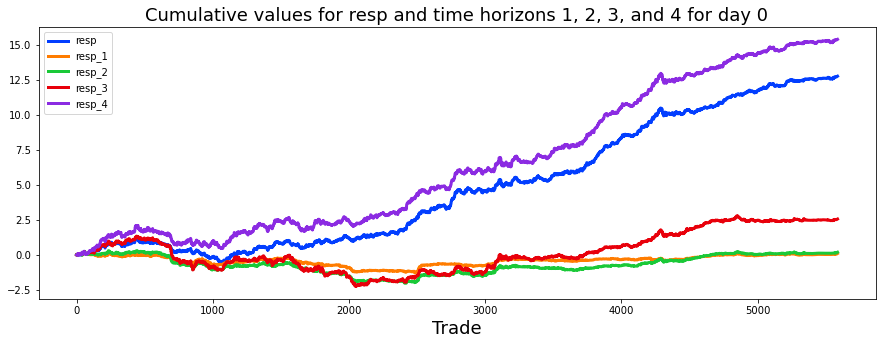

In [40]:
day_0 = train_data.loc[train_data['date'] == 0]
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(day_0['resp']).cumsum()
resp_1= pd.Series(day_0['resp_1']).cumsum()
resp_2= pd.Series(day_0['resp_2']).cumsum()
resp_3= pd.Series(day_0['resp_3']).cumsum()
resp_4= pd.Series(day_0['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative values for resp and time horizons 1, 2, 3, and 4 for day 0", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

In [41]:
day_0.describe().style.background_gradient(cmap=colorMap)

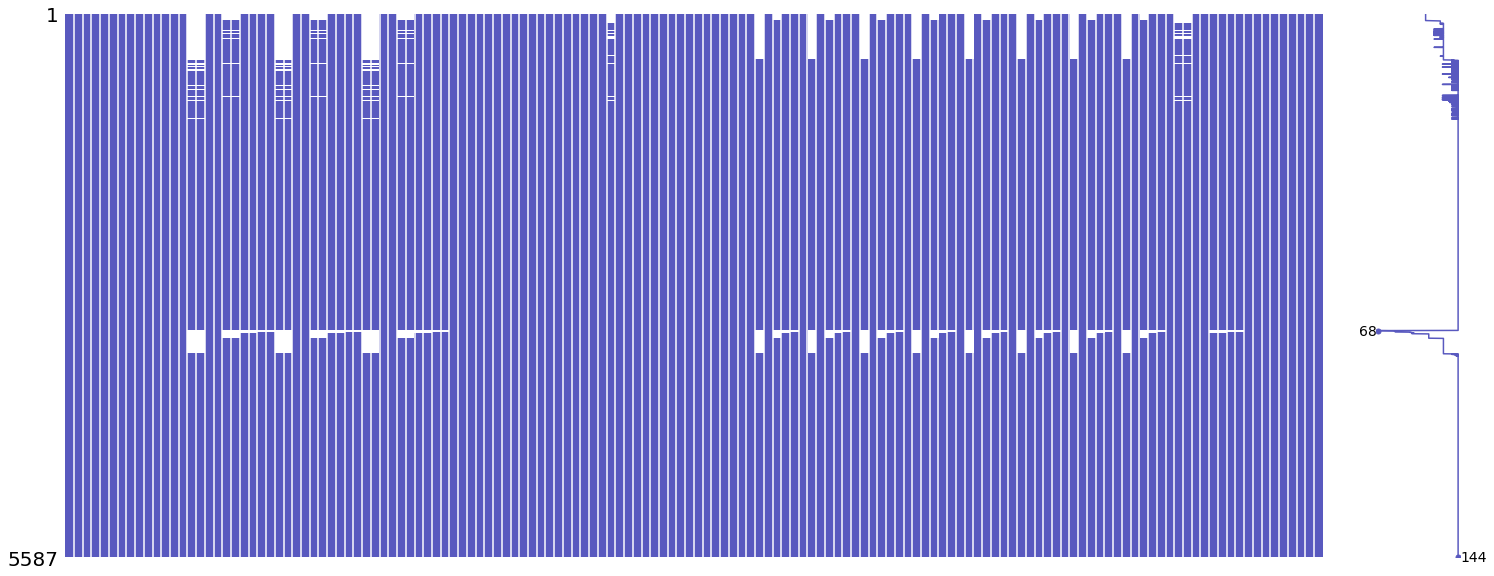

In [42]:
msno.matrix(day_0, color=(0.35, 0.35, 0.75));

发现缺失的部分都是成对存在的，maybe是股票啥啥啥时间？

In [44]:
gone = train_data.isnull().sum()
px.bar(gone, color=gone.values, title="Total number of missing values for each column").show()

Target looks like classification
Showing only top 10 of 140 continuous features
Linear Discriminant Analysis training set score: 0.880


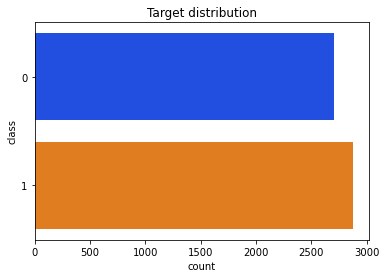

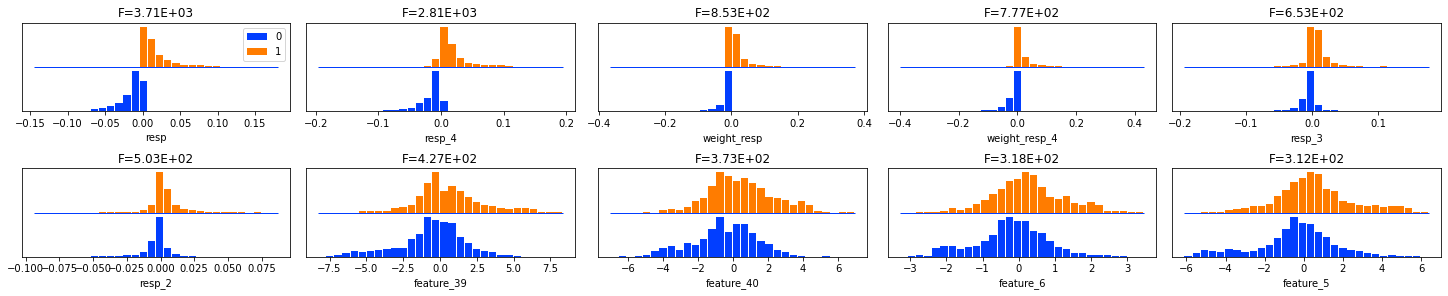

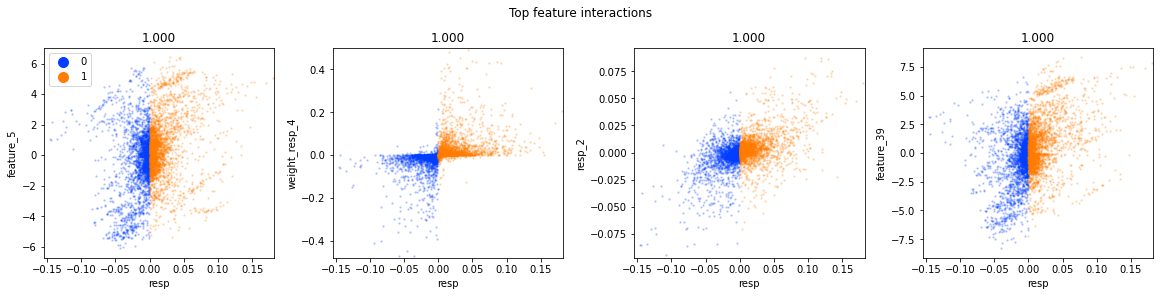

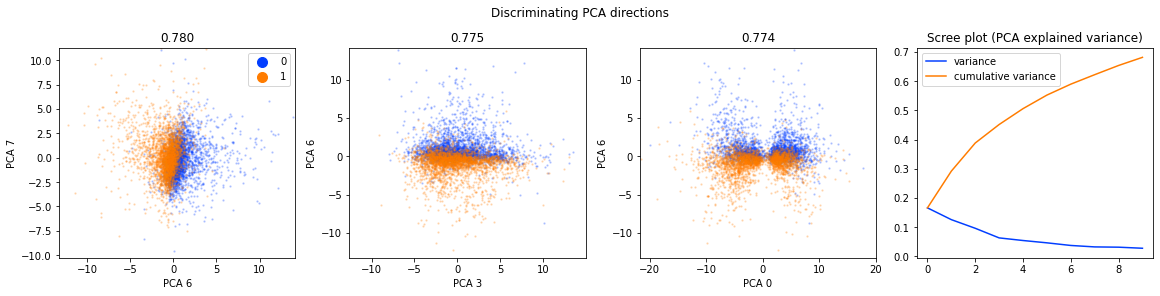

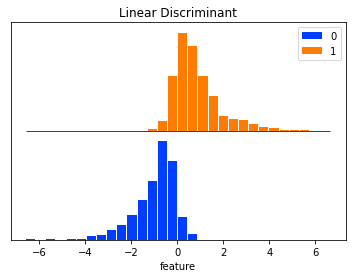

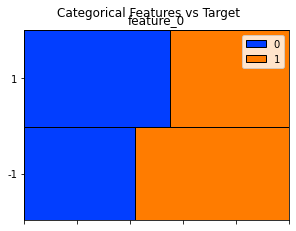

In [45]:
dabl.plot(day_0, target_col="action")

action是平衡的

Target looks like regression
Showing only top 10 of 139 continuous features


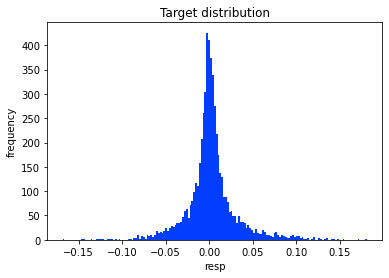

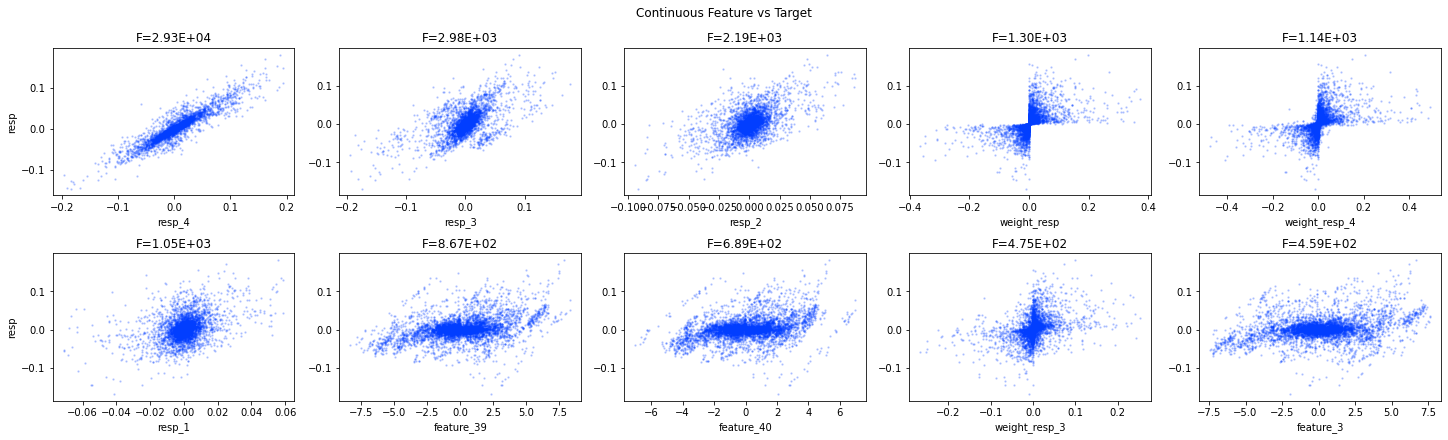

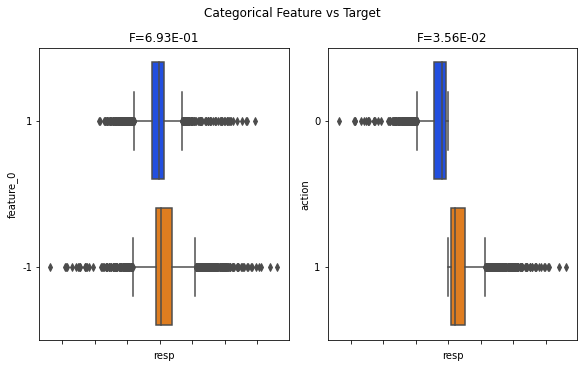

In [46]:
dabl.plot(day_0, target_col="resp")

## Random Forest

In [47]:
X_train = day_0.loc[:, day_0.columns.str.contains('feature')]
X_train = X_train.fillna(X_train.mean())
# our target is the action
y_train = day_0['resp']

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_features='auto')
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [49]:
import eli5
from eli5.sklearn import PermutationImportance
perm_import = PermutationImportance(regressor, random_state=1).fit(X_train, y_train)
# visualize the results
eli5.show_weights(perm_import, top=15, feature_names = X_train.columns.tolist())

## feature相关性

In [50]:
day_100  = train_data.loc[train_data['date'] == 100]
day_200  = train_data.loc[train_data['date'] == 200]
day_100_and_200 = pd.concat([day_100, day_200])
day_100_and_200.corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

### Tag28: feature_{120...129}

In [52]:
subset = day_100_and_200[["feature_120","feature_121","feature_122","feature_123","feature_124","feature_125","feature_126","feature_127","feature_128","feature_129"]]
subset.corr(method='pearson').style.background_gradient(cmap='coolwarm', low=1, high=0, axis=None).set_precision(2)

都是Tag28的feature